# <center> Movie Review Sentiment Analysis </center>
## <center> Classify the sentiment of sentences from the Rotten Tomatoes dataset </center>

##  Contents
* [Introduction](#introduction)
* [EDA](#eda)
* [Different Machine Learning Models ](#ml)
  *  [  N-Grams Method ](#N-Grams)
  *  [GRU model ](#gru)
  *  [ LSTM model](#lstm)
  *  [Bidirectional-GRU model](#bgru)
  *  [ CNN model ](#cnn)
  *  [ CNN-GRU ](#cgru)
  *  [GRU-CNN ](#gruc)
* [Final Ensemble](#en) 
    

<a id='introduction'></a>
## <center> Introduction </center>
The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

In [1]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='eda'></a>
## <center>EDA</center>
Basic exploration of data to check labels , the number of phrases for each label and average phrase length in the each sentiment.

In [2]:
from google.colab import files
uploaded = files.upload()           # Upload [train.tsv] [test.tsv] [sampleSubmission.csv]

Saving sampleSubmission.csv to sampleSubmission.csv
Saving test.tsv to test.tsv
Saving train.tsv to train.tsv


In [3]:
train = pd.read_csv('train.tsv',sep = '\t')
test = pd.read_csv('test.tsv',sep = '\t')
sub = pd.read_csv('sampleSubmission.csv')

In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
class_count = train['Sentiment'].value_counts()
class_count

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [7]:
np.array(class_count.index)

array([2, 3, 1, 4, 0])

In [8]:
np.array(class_count.values)

array([79582, 32927, 27273,  9206,  7072])

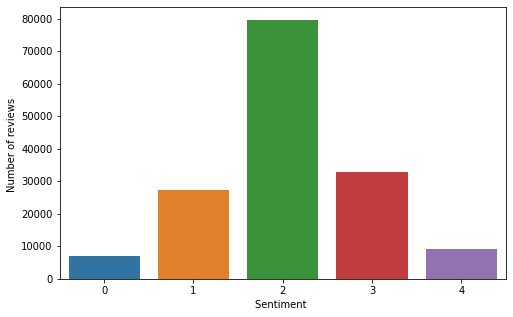

In [9]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x= x, y= y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')
plt.show()


In [10]:
print('Number of sentences in training set:', len(train['SentenceId'].unique()))
print('Number of sentences in test set:', len(test['SentenceId'].unique()))

print('Average words per sentence in train:', train.groupby('SentenceId')['Phrase'].count().mean())
print('Average words per sentence in test:', test.groupby('SentenceId')['Phrase'].count().mean())

Number of sentences in training set: 8529
Number of sentences in test set: 3310
Average words per sentence in train: 18.297572986282095
Average words per sentence in test: 20.027794561933536


### Using Word Clouds to see the higher fequency words from each sentiment

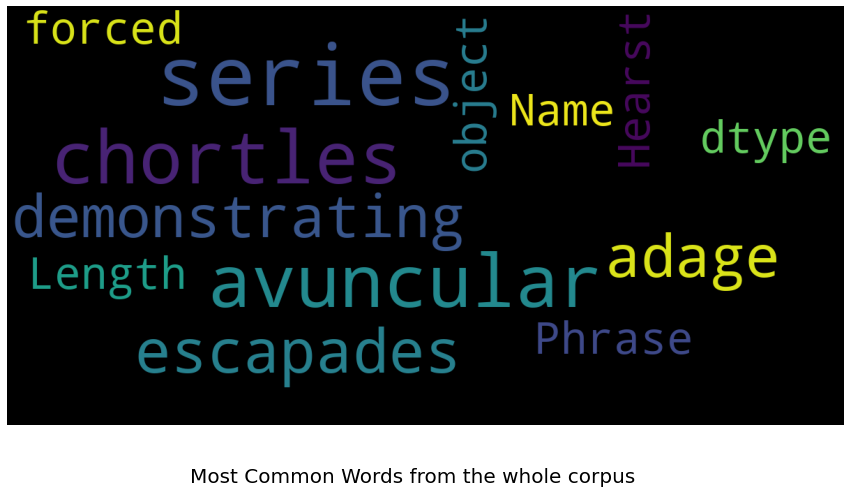

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                background_color= 'black',
                stopwords= stopwords,
                max_words= 200,
                max_font_size= 40, 
                scale= 3,
                random_state= 1 # chosen at random by flipping a coin; it was heads
                              ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(train['Phrase'],'Most Common Words from the whole corpus')

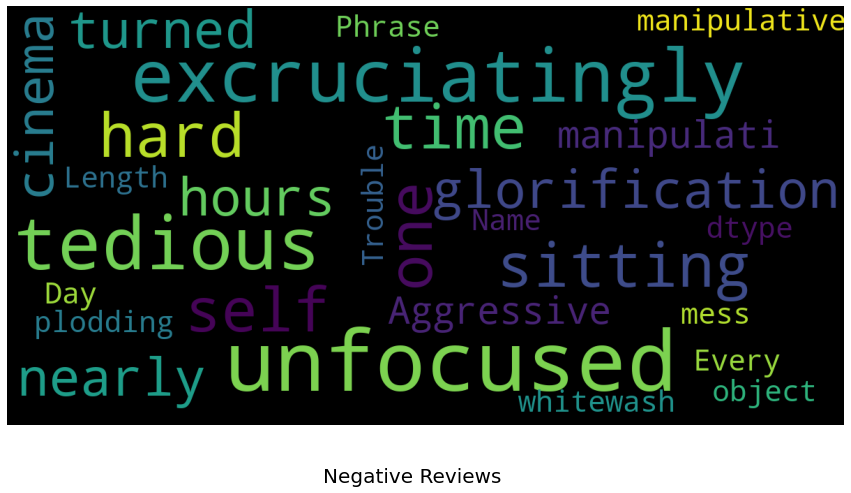

In [12]:
show_wordcloud(train[train['Sentiment'] == 0]['Phrase'], 'Negative Reviews')

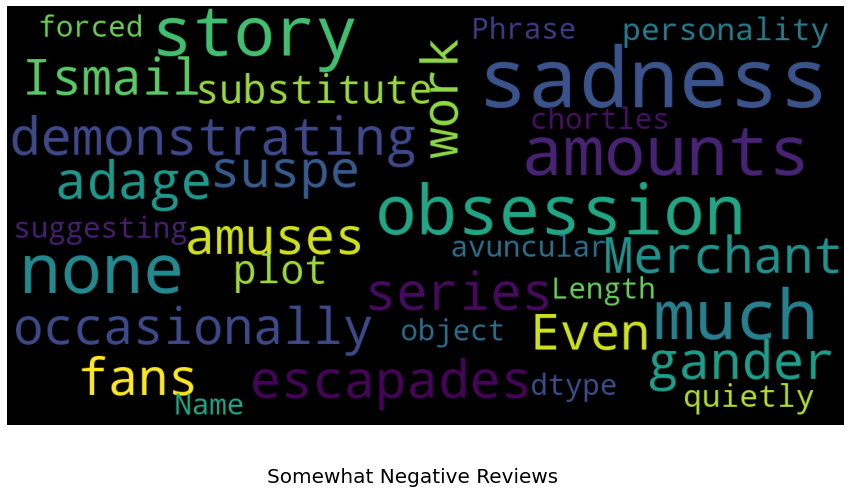

In [13]:
show_wordcloud(train[train['Sentiment'] == 1]['Phrase'], 'Somewhat Negative Reviews')

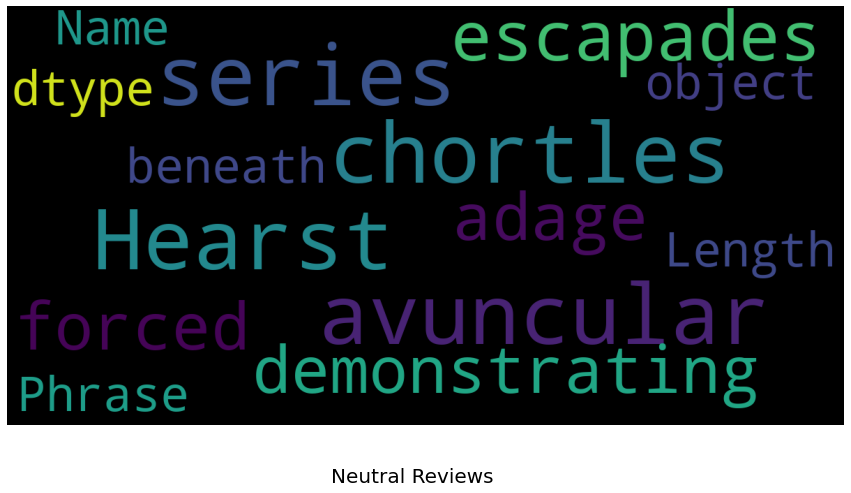

In [14]:
show_wordcloud(train[train['Sentiment'] == 2]['Phrase'],'Neutral Reviews')

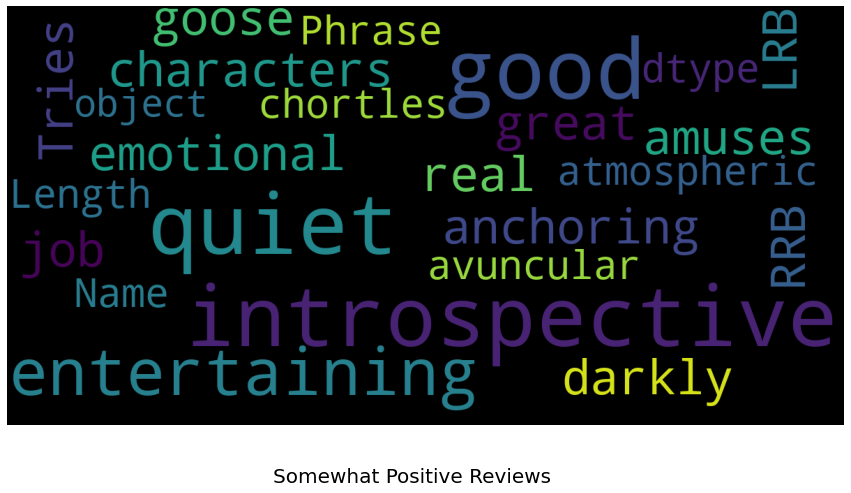

In [15]:
show_wordcloud(train[train['Sentiment'] == 3]['Phrase'],'Somewhat Positive Reviews')

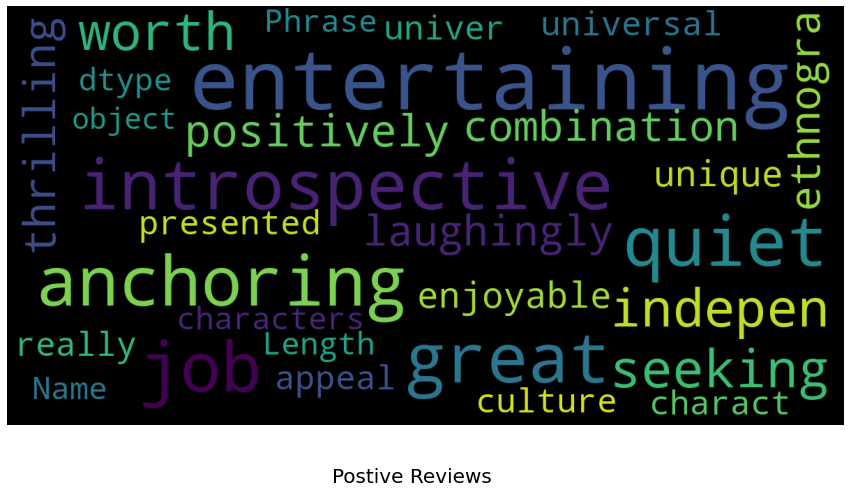

In [16]:
show_wordcloud(train[train['Sentiment'] == 4]['Phrase'],'Postive Reviews')

<a id='ml'></a>
## <center>  Different Machine Learning Models </center>


In [17]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()

<a id='N-Grams'></a>
##  <center>1.N-Grams</center>

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
vectorizer.fit(full_text)         # Here I want to convert the Phrases of [train] and [test] to tfidf values
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [19]:
y = train['Sentiment']

In [20]:
from sklearn.model_selection import train_test_split
X_train , X_val, y_train , y_val = train_test_split(train_vectorized, y, test_size = 0.2)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Training Logistic Reagression model and an SVM.

In [23]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(X_train, y_train)
print(classification_report( y_val, ovr.predict(X_val) ))
print(accuracy_score( y_val, ovr.predict(X_val) ))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.66      0.17      0.27      1485
           1       0.56      0.33      0.41      5467
           2       0.65      0.91      0.76     15959
           3       0.60      0.42      0.50      6483
           4       0.67      0.22      0.33      1818

    accuracy                           0.63     31212
   macro avg       0.63      0.41      0.45     31212
weighted avg       0.62      0.63      0.59     31212

0.6315519671921056


In [24]:
svm = LinearSVC()
svm.fit(X_train, y_train)

print(classification_report( y_val, svm.predict(X_val) ))
print(accuracy_score( y_val, svm.predict(X_val) ))

              precision    recall  f1-score   support

           0       0.51      0.38      0.43      1485
           1       0.55      0.49      0.52      5467
           2       0.73      0.82      0.77     15959
           3       0.59      0.53      0.56      6483
           4       0.54      0.43      0.48      1818

    accuracy                           0.66     31212
   macro avg       0.58      0.53      0.55     31212
weighted avg       0.65      0.66      0.65     31212

0.6566705113417917


In [25]:
estimators = [ ('svm', svm) , ('ovr', ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(X_train, y_train)

print(classification_report( y_val, clf.predict(X_val) ))
print(accuracy_score( y_val, clf.predict(X_val) ))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.51      0.38      0.44      1485
           1       0.54      0.50      0.52      5467
           2       0.68      0.86      0.76     15959
           3       0.62      0.41      0.49      6483
           4       0.68      0.21      0.32      1818

    accuracy                           0.65     31212
   macro avg       0.61      0.47      0.51     31212
weighted avg       0.64      0.65      0.62     31212

0.6457452261950531


In [26]:
from tensorflow.keras.utils import to_categorical
target= train.Sentiment.values
y= to_categorical(target)
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [27]:
max_features = 13000            # here i will determine the len of Phrases because if we run len(train['Phrase']) will be 156060, it's very huge data so we will take only 13000
max_words = 50                  # make padding for every Phrase in dataframe, by take only 50 words per Phrase.
batch_size = 128
epochs = 3
num_classes= 5

In [28]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(train['Phrase'], y, test_size = 0.2)

In [29]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers import SpatialDropout1D, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [30]:
tokenizer = Tokenizer(num_words= max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)


In [31]:
len(test['Phrase'])

66292

In [32]:
X_test = tokenizer.texts_to_sequences(test['Phrase'])

In [33]:
print(len(X_train))
print(len(X_val))
print(len(X_test))


124848
31212
66292


In [34]:
# X_train للجمل كلها عشان تبقي نفس الطول في ال padding أنا هنا هعمل
# Here i will make the padding for all Phrases to be all in the same length in [X_train, X_val, X_test]
X_train =pad_sequences(X_train, maxlen= max_words)
X_val = pad_sequences(X_val, maxlen= max_words)
X_test =pad_sequences(X_test, maxlen=max_words)

<a id='gru'></a>
## <center>GRU</center>

In [35]:
model_GRU= Sequential()
model_GRU.add( Embedding(max_features, 100, mask_zero=True) )
model_GRU.add( GRU(64, dropout=0.4, return_sequences=True) )
model_GRU.add( GRU(32, dropout=0.5, return_sequences=False) )
model_GRU.add( Dense(num_classes, activation='softmax') )
model_GRU.compile(loss='categorical_crossentropy', optimizer= Adam(lr = 0.001), metrics=['accuracy'])
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1300000   
                                                                 
 gru (GRU)                   (None, None, 64)          31872     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 1,341,445
Trainable params: 1,341,445
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
%%time
history1= model_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
976/976 [==============================] - 143s 138ms/step - loss: 1.0211 - accuracy: 0.5959 - val_loss: 0.8716 - val_accuracy: 0.6531
Epoch 2/3
976/976 [==============================] - 133s 137ms/step - loss: 0.8296 - accuracy: 0.6624 - val_loss: 0.8381 - val_accuracy: 0.6678
Epoch 3/3
976/976 [==============================] - 132s 135ms/step - loss: 0.7742 - accuracy: 0.6824 - val_loss: 0.8207 - val_accuracy: 0.6747
CPU times: user 11min 37s, sys: 25.8 s, total: 12min 3s
Wall time: 6min 48s


In [37]:
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [38]:
y_pred1= model_GRU.predict(X_test, verbose=1)
classes_y_pred1= np.argmax(y_pred1, axis=1)
sub.Sentiment= classes_y_pred1          # make a new column in sub dataframe called it Sentiment
sub.to_csv('sub1_GRU.csv', index=False)
sub.head()

2072/2072 [==============================] - 34s 15ms/step


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [39]:
model2_GRU= Sequential()
model2_GRU.add(Embedding(max_features, 100, mask_zero=True))
model2_GRU.add(GRU(64, dropout= 0.4, return_sequences=True))
model2_GRU.add(GRU(32, dropout= 0.5, return_sequences=False))
model2_GRU.add(Dense(num_classes, activation='sigmoid'))
model2_GRU.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])
model2_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1300000   
                                                                 
 gru_2 (GRU)                 (None, None, 64)          31872     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,341,445
Trainable params: 1,341,445
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
%%time
history2= model2_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
976/976 [==============================] - 145s 141ms/step - loss: 0.3679 - accuracy: 0.5747 - val_loss: 0.3129 - val_accuracy: 0.6443
Epoch 2/3
976/976 [==============================] - 135s 139ms/step - loss: 0.2971 - accuracy: 0.6611 - val_loss: 0.2996 - val_accuracy: 0.6634
Epoch 3/3
976/976 [==============================] - 137s 141ms/step - loss: 0.2794 - accuracy: 0.6849 - val_loss: 0.2966 - val_accuracy: 0.6684
CPU times: user 11min 49s, sys: 26.4 s, total: 12min 15s
Wall time: 7min 28s


In [42]:
y_pred2= model2_GRU.predict(X_test, verbose=1)
classes_y_pred2= np.argmax(y_pred2, axis=1)
sub.Sentiment= classes_y_pred2
sub.to_csv('sub2_GRU.csv', index=False)
sub.head()

2072/2072 [==============================] - 41s 16ms/step


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


<a id='lstm'></a>
## <center>LSTM</center>

In [43]:
model3_LSTM= Sequential()
model3_LSTM.add( Embedding(max_features, 100, mask_zero=True) )
model3_LSTM.add( LSTM(64, dropout=0.4, return_sequences=True) )
model3_LSTM.add( LSTM(32, dropout=0.5, return_sequences=False) )
model3_LSTM.add( Dense(num_classes, activation='sigmoid'))
model3_LSTM.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.001), metrics=['accuracy'])
model3_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1300000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,354,821
Trainable params: 1,354,821
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
%%time
history3= model3_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
976/976 [==============================] - 177s 173ms/step - loss: 0.4101 - accuracy: 0.5208 - val_loss: 0.3634 - val_accuracy: 0.5590
Epoch 2/3
976/976 [==============================] - 166s 170ms/step - loss: 0.3415 - accuracy: 0.5909 - val_loss: 0.3190 - val_accuracy: 0.6358
Epoch 3/3
976/976 [==============================] - 165s 169ms/step - loss: 0.2945 - accuracy: 0.6594 - val_loss: 0.3031 - val_accuracy: 0.6556
CPU times: user 14min 30s, sys: 41 s, total: 15min 11s
Wall time: 8min 29s


In [45]:
y_pred3= model3_LSTM.predict(X_test, verbose=1)
classes_y_pred3= np.argmax(y_pred3, axis=1)
sub.Sentiment= classes_y_pred3
sub.to_csv('sub3_LSTM.csv', index=False)
sub.head()

2072/2072 [==============================] - 41s 18ms/step


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


<a id='bgru'></a>
## <center>Bidirectional-GRU</center>

In [46]:
model4_BGRU = Sequential()
model4_BGRU.add(Embedding(max_features, 100, input_length= max_words))
model4_BGRU.add(SpatialDropout1D(0.25))
model4_BGRU.add(Bidirectional(GRU(64, dropout=0.4, return_sequences = True)))
model4_BGRU.add(Bidirectional(GRU(32, dropout=0.5, return_sequences = False)))
model4_BGRU.add(Dense(num_classes, activation='sigmoid'))
model4_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_BGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          63744     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                      

In [47]:
%%time
history4= model4_BGRU.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
976/976 [==============================] - 239s 237ms/step - loss: 0.3479 - accuracy: 0.5879 - val_loss: 0.3023 - val_accuracy: 0.6518
Epoch 2/3
976/976 [==============================] - 230s 236ms/step - loss: 0.2896 - accuracy: 0.6663 - val_loss: 0.2903 - val_accuracy: 0.6697
Epoch 3/3
976/976 [==============================] - 232s 238ms/step - loss: 0.2741 - accuracy: 0.6867 - val_loss: 0.2863 - val_accuracy: 0.6735
CPU times: user 20min 40s, sys: 1min 6s, total: 21min 46s
Wall time: 11min 41s


In [48]:
y_pred4= model4_BGRU.predict(X_test, verbose=1)
classes_y_pred4= np.argmax(y_pred4, axis=1)
sub.Sentiment= classes_y_pred4
sub.to_csv('sub4_BGRU.csv', index=False)
sub.head()

2072/2072 [==============================] - 42s 19ms/step


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


<a id='cnn'></a>
## <center>CNN</center>

In [49]:
model5_CNN= Sequential()
model5_CNN.add(Embedding(max_features, 100, input_length=max_words))
model5_CNN.add(Dropout(0.2))
model5_CNN.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', strides=1))
model5_CNN.add(GlobalMaxPooling1D())
model5_CNN.add(Dense(128, activation='relu'))
model5_CNN.add(Dropout(0.2))
model5_CNN.add(Dense(num_classes, activation='sigmoid'))
model5_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [50]:
%%time
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

history5= model5_CNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=batch_size, verbose=1, callbacks = [early_stop])

Epoch 1/3
976/976 [==============================] - 45s 45ms/step - loss: 0.3489 - accuracy: 0.5909 - val_loss: 0.3032 - val_accuracy: 0.6532
Epoch 2/3
976/976 [==============================] - 44s 45ms/step - loss: 0.2853 - accuracy: 0.6706 - val_loss: 0.2907 - val_accuracy: 0.6626
Epoch 3/3
976/976 [==============================] - 44s 45ms/step - loss: 0.2613 - accuracy: 0.6993 - val_loss: 0.2864 - val_accuracy: 0.6715
CPU times: user 3min 45s, sys: 7.96 s, total: 3min 53s
Wall time: 2min 22s


In [51]:
y_pred5= model5_CNN.predict(X_test, verbose=1)
classes_y_pred5= np.argmax(y_pred5, axis=1)
sub.Sentiment= classes_y_pred5
sub.to_csv('sub5_CNN.csv', index=False)
sub.head()

2072/2072 [==============================] - 6s 3ms/step


,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,2
4,156065,2


<a id='cgru'></a>
## <center>CNN-GRU</center>

In [52]:
model6_CnnGRU= Sequential()
model6_CnnGRU.add(Embedding(max_features,100,input_length=max_words))
model6_CnnGRU.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model6_CnnGRU.add(MaxPooling1D(pool_size=2))
model6_CnnGRU.add(Dropout(0.25))
model6_CnnGRU.add(GRU(128,return_sequences=True))
model6_CnnGRU.add(Dropout(0.3))
model6_CnnGRU.add(Flatten())
model6_CnnGRU.add(Dense(128, activation='relu'))
model6_CnnGRU.add(Dropout(0.5))
model6_CnnGRU.add(Dense(5,activation='sigmoid'))
model6_CnnGRU.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model6_CnnGRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 25, 64)            0         
                                                                 
 gru_6 (GRU)                 (None, 25, 128)           74496     
                                                                 
 dropout_3 (Dropout)         (None, 25, 128)           0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
%%time
history6= model6_CnnGRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/3
976/976 [==============================] - 113s 113ms/step - loss: 0.3571 - accuracy: 0.5777 - val_loss: 0.3036 - val_accuracy: 0.6452
Epoch 2/3
976/976 [==============================] - 114s 117ms/step - loss: 0.2917 - accuracy: 0.6638 - val_loss: 0.2893 - val_accuracy: 0.6663
Epoch 3/3
976/976 [==============================] - 110s 113ms/step - loss: 0.2685 - accuracy: 0.6915 - val_loss: 0.2873 - val_accuracy: 0.6729
CPU times: user 9min 16s, sys: 28.1 s, total: 9min 44s
Wall time: 6min 24s


In [54]:
y_pred6= model6_CnnGRU.predict(X_test, verbose=1)
classes_y_pred6= np.argmax(y_pred6, axis=1)
sub.Sentiment= classes_y_pred6
sub.to_csv('sub6_CnnGRU.csv', index=False)
sub.head()

2072/2072 [==============================] - 21s 10ms/step


,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,2
4,156065,3


<a id='gruc'></a>
## <center>GRU-CNN</center>

In [55]:
model7_GruCNN = Sequential()
model7_GruCNN.add(Embedding(max_features,100,input_length=max_words))
model7_GruCNN.add(Dropout(0.2))
model7_GruCNN.add(Bidirectional(GRU(units=128 , return_sequences=True)))
model7_GruCNN.add(Conv1D(32 , kernel_size=3 , padding='same' , activation='relu'))
model7_GruCNN.add(GlobalMaxPooling1D())
model7_GruCNN.add(Dense(units = 64 , activation='relu'))
model7_GruCNN.add(Dropout(0.5))
model7_GruCNN.add(Dense(units=5,activation='sigmoid'))
model7_GruCNN.compile(loss='binary_crossentropy' , optimizer = 'adam' , metrics=['accuracy'])
model7_GruCNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 dropout_5 (Dropout)         (None, 50, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 256)          176640    
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 32)            24608     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 64)               

In [56]:
%%time
history7 = model7_GruCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/4
976/976 [==============================] - 322s 325ms/step - loss: 0.3666 - accuracy: 0.5714 - val_loss: 0.3024 - val_accuracy: 0.6484
Epoch 2/4
976/976 [==============================] - 315s 322ms/step - loss: 0.2966 - accuracy: 0.6605 - val_loss: 0.2920 - val_accuracy: 0.6631
Epoch 3/4
976/976 [==============================] - 314s 321ms/step - loss: 0.2742 - accuracy: 0.6889 - val_loss: 0.2878 - val_accuracy: 0.6730
Epoch 4/4
976/976 [==============================] - 329s 337ms/step - loss: 0.2586 - accuracy: 0.7057 - val_loss: 0.2891 - val_accuracy: 0.6773
CPU times: user 36min 51s, sys: 2min 30s, total: 39min 22s
Wall time: 21min 25s


In [57]:
y_pred7= model7_GruCNN.predict(X_test, verbose=1)
classes_y_pred7= np.argmax(y_pred7, axis=1)
sub.Sentiment= classes_y_pred7
sub.to_csv('sub7_GruCNN.csv', index=False)
sub.head()

2072/2072 [==============================] - 49s 23ms/step


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


<a id='en'></a>
## <center>Ensembling all the predictions</center>

In [58]:
sub_all= pd.DataFrame({'model1': classes_y_pred1, 'model2': classes_y_pred2, 'model3': classes_y_pred3, 'model4': classes_y_pred4, 'model5': classes_y_pred5, 'model6': classes_y_pred6, 'model7':classes_y_pred7})
sub_all.head()

,model1,model2,model3,model4,model5,model6,model7
0,2,2,2,2,3,3,2
1,2,2,2,2,3,3,2
2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2
4,2,2,2,2,2,3,2


In [60]:
# To find the mode manually, arrange the numbers in ascending or descending order, then count how often each number appears. The number that appears most often is the mode. 
# Mode أكثر رقم متكرر في كل صف هيبقي هو ده ال
sub_all.agg('mode', axis=1)[0].values

array([2., 2., 2., ..., 1., 1., 1.])

In [61]:
pred_mode= sub_all.agg('mode', axis=1)[0].values

pred_mode=[int(i) for i in pred_mode]
sub.Sentiment= pred_mode
sub.to_csv('ensemble_mode.csv', index=False)
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


________
### <center> Finally, We predicted the X_test in 7 different ways then return the final prediction by calculate the mode (Which is the most prediction was occur in every row) </center>